In [1]:
import os

# set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

from numpyro import set_platform

set_platform('gpu')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(context='notebook', style='white', font_scale=1.6, color_codes=True)

In [3]:
import arviz as az
import pandas as pd
import equinox as eqx
import jax.numpy as jnp
import numpyro.distributions as dist
from jax import random, nn, vmap
from functools import partial
import optax

from numpyro.infer import log_likelihood, Predictive

from models import exact_blr, log_ratio, BayesRegression, SVIRegression, BMRRegression
from networks import MLP

rng_key = random.PRNGKey(3742)

In [4]:
# path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wpbc.data'
# df6 = pd.read_csv(path, header=None)

# X_bern = jnp.array(df6.loc[:, 3:33])
# X_bern = (X_bern - X_bern.mean(0)) / X_bern.std(0)

# cov_matrix = jnp.cov(X_bern.T)
# eigen_values, eigen_vectors = jnp.linalg.eigh(cov_matrix)
# W_pca = eigen_vectors / jnp.sqrt(eigen_values)

# Xq_bern = X_bern @ W_pca
# Xq_bern /= jnp.std(Xq_bern, 0)
# y_bern = jnp.array(df6[1] == 'R')

In [4]:
# load data
from sklearn.datasets import fetch_openml

mice = fetch_openml(name='miceprotein', version=4, parser="auto")
music = fetch_openml(name='GeographicalOriginalofMusic', parser="auto")
scene = fetch_openml(name='scene', version=1, parser="auto")

In [5]:
def format_and_whiten(dataset):
    X = jnp.nan_to_num(dataset.data.astype(float).values)
    X = (X - X.mean(0)) / jnp.clip(X.std(0), a_min=1e-3)

    cov_matrix = jnp.cov(X.T)
    eigen_values, eigen_vectors = jnp.linalg.eigh(cov_matrix)
    W_pca = eigen_vectors / jnp.sqrt(eigen_values)
    
    X = X @ W_pca
    y = dataset.target
    if y.dtype == 'category':
        name2int = dict([(idx, i) for i, idx in enumerate(y.unique())])
        labels = [name2int[idx] for idx in y.values]
        y = jnp.array(labels)
    else:
        y = jnp.array(y.values)

    return X, y

In [11]:
def compute_loo_nuts(dataset, regtype, seed=0):
    X, y = format_and_whiten(dataset)
    n, D = X.shape
    rng_key = random.PRNGKey(seed)
    loos = {}
    for depth in [0, 1, 2, 3]:
        loos[depth] = {}
        for width in [10, 20, 30, 40]:
            print(depth, width)
            rng_key, _rng_key = random.split(rng_key)
            nnet = MLP(D, 1, width, depth, use_bias=True, key=_rng_key)

            rng_key, _rng_key = random.split(rng_key)
            bayesreg = BayesRegression(_rng_key, X, nnet, regtype=regtype)

            smpl = bayesreg.fit(
                y, 
                num_samples=250, 
                warmup_steps=500, 
                num_chains=4,
                progress_bar=False
            )

            idata = az.from_numpyro(bayesreg.mcmc)
            loos[depth][width] = az.loo(idata)

            if depth == 0:
                break

    return loos

def estimate_loo(smpl, model, y):
    dims = {'obs': ['sample']}

    post_smpl = {}
    for key in smpl:
        if key != 'obs':
            post_smpl[key] = jnp.expand_dims(smpl[key], 0)

    log_lik = log_likelihood(
        model, post_smpl, parallel=True, batch_ndims=2, obs=y
    )

    idata = az.convert_to_inference_data(post_smpl)
    idata.add_groups(log_likelihood=log_lik, dims=dims)
    return az.loo(idata, pointwise=True)

def compute_loo_svi(dataset, regtype, seed=0):
    X, y = format_and_whiten(dataset)
    n, D = X.shape
    rng_key = random.PRNGKey(seed)
    loos = {}
    for depth in [0, 1, 2, 3]:
        loos[depth] = {}
        autoguide = 'multivariate' if depth == 0 else 'mean-field'
        
        for width in [10, 20, 30, 40]:
            print(depth, width)
            rng_key, _rng_key = random.split(rng_key)
            nnet = MLP(D, 1, width, depth, use_bias=True, key=_rng_key)

            rng_key, _rng_key = random.split(rng_key)
            svireg = SVIRegression(_rng_key, X, nnet, regtype=regtype)
        
            smpl = svireg.fit(
                y, 
                num_samples=1000, 
                num_steps=50_000,
                autoguide=autoguide,
                progress_bar=True,
                opt_kwargs = {'learning_rate': 1e-3}
            )

            loos[depth][width] = estimate_loo(smpl, svireg.model, y)

            if depth == 0:
                break

    return loos


def compute_loo_bmr(dataset, regtype, seed=0):
    X, y = format_and_whiten(dataset)
    n, D = X.shape
    rng_key = random.PRNGKey(seed)
    loos = {'No-BMR': {regtype: {}}, 'BMR': {regtype: {}}}
    for depth in [0, 1, 2, 3]:
        loos['No-BMR'][regtype][depth] = {}
        loos['BMR'][regtype][depth] = {}

        posterior = 'multivariate' if depth == 0 else 'normal'
        
        for width in [10, 20, 30, 40]:
            print(depth, width)
            rng_key, _rng_key = random.split(rng_key)
            nnet = MLP(D, 1, width, depth, use_bias=False, key=_rng_key)

            rng_key, _rng_key = random.split(rng_key)
            bmrreg = BMRRegression(_rng_key, X, nnet, regtype=regtype, posterior=posterior)
        
            bmrreg.fit(
                y, 
                num_samples=1000, 
                num_steps=50_000,
                progress_bar=True,
                opt_kwargs = {'learning_rate': 1e-4}
            )
            loos['No-BMR'][regtype][depth][width] = estimate_loo(bmrreg.samples, bmrreg.model, y)

            results, smpl = bmrreg.bmr('mean-field', num_steps=20_000, progress_bar=False)
            print('<dF> + F: ', results.losses[-1000:].mean() + bmrreg.results.losses[-1000:].mean())

            loos['BMR'][regtype][depth][width] = estimate_loo(smpl, bmrreg.model, y)

            if depth == 0:
                break

    return loos


def compute_loo_map(dataset, regtype, seed=0):
    X, y = format_and_whiten(dataset)
    n, D = X.shape
    rng_key = random.PRNGKey(seed)
    loos = {}
    for depth in [0, 1, 2, 3]:
        loos[depth] = {}
        
        for width in [10, 20, 30, 40]:
            print(depth, width)
            rng_key, _rng_key = random.split(rng_key)
            nnet = MLP(D, 1, width, depth, use_bias=True, key=_rng_key)

            rng_key, _rng_key = random.split(rng_key)
            bmrreg = BMRRegression(_rng_key, X, nnet, regtype=regtype, posterior='delta')
        
            bmrreg.fit(
                y, 
                num_samples=2, 
                num_steps=30_000,
                progress_bar=False,
                opt_kwargs = {'learning_rate': 1e-4}
            )
            loos[depth][width] = estimate_loo(bmrreg.samples, bmrreg.model, y)

            if depth == 0:
                break

    return loos

try:
    loos_all = jnp.load('real_data_loos.npz', allow_pickle=True)['loos'].item()
except:   
    loos_all = {
        'NUTS': {},
        'SVI': {},
        'No-BMR': {},
        'BMR': {},
        'MAP': {}
    }

### No-U-turn sampler

In [12]:
for method, data in zip(['multinomial'], [mice]):
    loos_all['NUTS'][method] = compute_loo_nuts(data, method, 10111)
    jnp.savez('real_data_loos.npz', loos=loos_all)

0 10


### Stochastic variational inference

In [ ]:
for method, data in zip(['multinomial'], [mice]):
    loos_all['SVI'][method] = compute_loo_svi(data, method, 101)
    jnp.savez('real_data_loos.npz', loos=loos_all)

### Stochastic Bayesian model reduction

In [ ]:
for method, data in zip(['multinomial'], [mice]):
    tmp = compute_loo_bmr(data, method, 101)
    loos_all['No-BMR'][method] = tmp['No-BMR'][method]
    loos_all['BMR'][method] = tmp['BMR'][method]
    jnp.savez('real_data_loos.npz', loos=loos_all)

In [ ]:
for method, data in zip(['multinomial'], [mice]):
    loos_all['MAP'][method] = compute_loo_map(data, method, 101)
    jnp.savez('real_data_loos.npz', loos=loos_all)

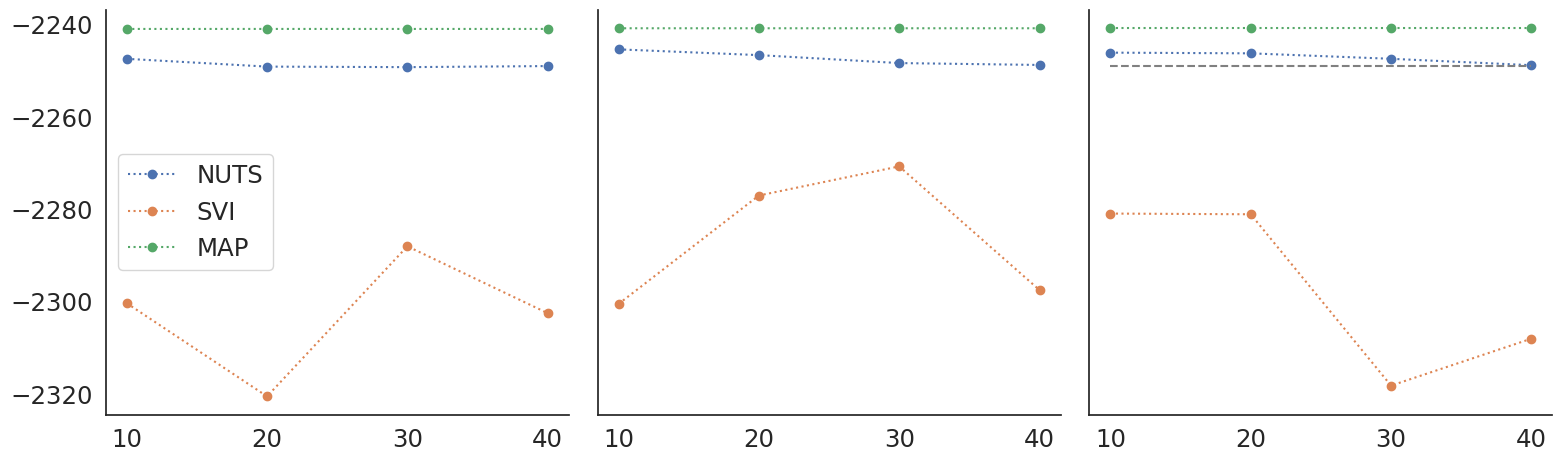

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey='row')

widths = [10, 20, 30, 40]
for j, tip in enumerate(['multinomial']):
    for d in [1, 2, 3]:
        for method in ['NUTS', 'SVI', 'MAP']:
            axes[d-1].plot(widths, [loos_all[method][tip][d][w].elpd_loo for w in widths], 'o:', label=method)

    axes[d-1].hlines(loos_all['NUTS'][tip][0][10].elpd_loo, 10, 40, color='gray', linestyle='--')
    # axes[d-1].hlines(loos_all['No-BMR']['multinomial'][0][10].elpd_loo, 10, 40, color='orange', linestyle='--')

axes[0].legend()
# axes[0].set_ylim([-2500, -2200])
fig.tight_layout()
sns.despine()